# Invertible Transformation
Ideally, there should be some invertible transformation, when done on the spatial intensity(X) that will generate a vector which can be linearly translated into fetal saturation(Y). Let's say this transformation is 
$$f(X) = M$$
Then there exists some relationship 
$$MN = f_{sat}$$
Where N is some learnable linear transformation. Additionally,
$$f^{-1}(M) = X$$

# Defining the Invertible NN
## Simple Upper Traingular Matrix/No Recombination 

In [19]:
import torch


class INN1(torch.nn.Module):
    """
    A special kind of invertible neural network that has only upper triangular elements in the weight matrix. This makes
    it such the inverse of the network always exists. However, the very last layer is regular linear layer. Internally,
    the non-linear activation is a sigmoid function. As it is invertible as opposed to a ReLU.
    """

    def __init__(self, feature_size: int, total_layer_count: int, output_size: int):
        super().__init__()
        self.feature_size = feature_size
        self.total_layer_count = total_layer_count
        self.output_size = output_size
        self.invertible_layers = []
        for _ in range(total_layer_count - 1):
            self.invertible_layers.append(torch.nn.Linear(feature_size, feature_size))
            self.invertible_layers.append(torch.nn.Sigmoid())
            self.invertible_layers.append(torch.nn.BatchNorm1d(feature_size))
        self.final_layer = torch.nn.Linear(feature_size, output_size)
        self._custom_weight_initialization()  # Upper Traingular weight matrix
        self.layers = self.invertible_layers + [self.final_layer]
        self.model = torch.nn.Sequential(*self.layers)

    def _custom_weight_initialization(self):
        for layer in self.invertible_layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data = torch.triu(layer.weight.data)

    def forward(self, x):
        return self.model(x)


model = INN1(10, 3, 1)
input = torch.randn(32, 10)
output = model(input)

# Test the model output
print("Expected Output Size: 32x1")
print("True Output Size:", output.size())

Expected Output Size: 32x1
True Output Size: torch.Size([32, 1])


In [20]:
import os
import pandas as pd
from typing import Tuple
from model_trainer import ModelTrainer, RandomSplit, DataLoaderGenerator, TorchLossWrapper
from model_trainer.misc import DATA_LOADER_INPUT_INDEX

os.environ["CUDA_VISIBLE_DEVICES"] = "3"


class CustomModelTrainer1(ModelTrainer):
    def __init__(self, model, dataloader_gen, validation_method, loss_func):
        super().__init__(model, dataloader_gen, validation_method, loss_func)
        assert hasattr(model, "invertible_layers"), "Model must have the invertible_layers property"

    def single_batch_train_run(self, data: Tuple) -> None:
        inputs = data[DATA_LOADER_INPUT_INDEX]

        # zero the parameter gradients
        self.optimizer.zero_grad()

        # forward + backward + optimize
        outputs = self.model(inputs)
        loss = self.loss_func(outputs, data, self.mode)
        loss.backward()

        # Customized Optimize Step -> Convert the gradient to an upper triangular matrix
        for layer in self.model.invertible_layers:
            if isinstance(layer, torch.nn.Linear):
                if layer.weight.grad is not None:
                    layer.weight.grad.data = torch.triu(layer.weight.grad.data)
                else:
                    raise ValueError("Gradient is None")

        self.optimizer.step()


# Test The Custom Model Trainer
dummy_data = torch.rand(256, 11)
dummy_data_table = pd.DataFrame(dummy_data.numpy(), columns=[f"Feature_{i}" for i in range(10)] + ["Target"])
feature_columns = [f"Feature_{i}" for i in range(10)]
target_columns = ["Target"]

dataloader_gen = DataLoaderGenerator(dummy_data_table, feature_columns, target_columns, 32, {"shuffle": True})
validation_method = RandomSplit(0.8)
criterion = TorchLossWrapper(torch.nn.MSELoss())

trainer = CustomModelTrainer1(model, dataloader_gen, validation_method, criterion)
trainer.set_optimizer(torch.optim.SGD, {"lr": 1e-3})

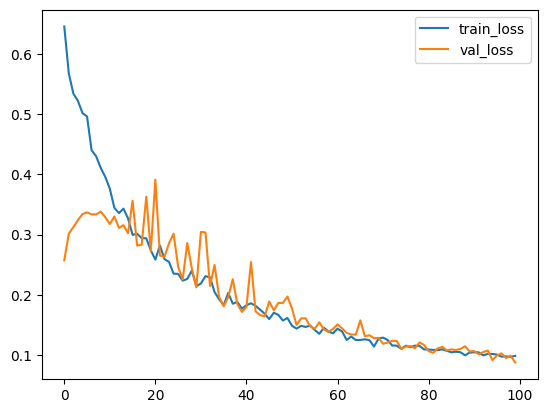

In [21]:
trainer.run(100)
criterion.loss_tracker.plot_losses()

# Using Affine Coupling/No Rearrangements

In [52]:
from typing import Literal


class AffineCouplingLayer(torch.nn.Module):
    def __init__(self, feature_size: int, half_to_transform: Literal["first", "second"]):
        assert feature_size % 2 == 0, "Feature size must be even"
        super().__init__()
        self.s = torch.nn.Sequential(
            torch.nn.Linear(feature_size // 2, feature_size // 2),
            torch.nn.ReLU()
        )
        self.t = torch.nn.Sequential(
            torch.nn.Linear(feature_size // 2, feature_size // 2),
            torch.nn.ReLU()
        )
        self.half_to_transform = half_to_transform
        self.transform_indices = slice(0, feature_size // 2) if half_to_transform == "first" else slice(feature_size // 2, feature_size)


    def forward(self, x):
        x_t = self.t(x[:, self.transform_indices])
        x_s = self.s(x[:, self.transform_indices])
        res = x.clone()
        res[:, self.transform_indices] = torch.exp(x[:, self.transform_indices] * x_s) + x_t
        x = res
        return x
        
        
class INN2(torch.nn.Module):
    """
    An invertible NN that uses affine coupling transformation. The network is split into two parts. The first part
    is a simple feedforward network that produces the scaling and translation parameters. The second part is the
    affine coupling transformation. This ensures the model is always invertible
    """
    def __init__(self, feature_size: int, total_layer_count: int, output_size: int):
        super().__init__()
        self.feature_size = feature_size
        self.total_layer_count = total_layer_count
        self.output_size = output_size
        self.layers = []
        for i in range(total_layer_count - 1):
            if i % 2 == 0:
                self.layers.append(AffineCouplingLayer(feature_size, "first"))
            else:
                self.layers.append(AffineCouplingLayer(feature_size, "second"))
            self.layers.append(torch.nn.BatchNorm1d(feature_size))
        self.layers.append(torch.nn.Linear(feature_size, output_size))
        self.model = torch.nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

# Test the Affine Coupling Layer
feature_size = 10
half_to_transform = "first"
layer = AffineCouplingLayer(feature_size, half_to_transform)
input = torch.randn(32, feature_size)
output = layer(input)
print("Affine Output Size", output.size())

# Test the INN2
model = INN2(10, 5, 1)
input = torch.randn(32, 10)
output = model(input)
print("Model Output Size", output.size())

Affine Output Size torch.Size([32, 10])
Model Output Size torch.Size([32, 1])


In [53]:
import os
import pandas as pd
from model_trainer import ModelTrainer, RandomSplit, DataLoaderGenerator, TorchLossWrapper

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Test The Custom Model Trainer
dummy_data = torch.rand(256, 11)
dummy_data_table = pd.DataFrame(dummy_data.numpy(), columns=[f"Feature_{i}" for i in range(10)] + ["Target"])
feature_columns = [f"Feature_{i}" for i in range(10)]
target_columns = ["Target"]

dataloader_gen = DataLoaderGenerator(dummy_data_table, feature_columns, target_columns, 32, {"shuffle": True})
validation_method = RandomSplit(0.8)
criterion = TorchLossWrapper(torch.nn.MSELoss())

trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer.set_optimizer(torch.optim.SGD, {"lr": 1e-3})

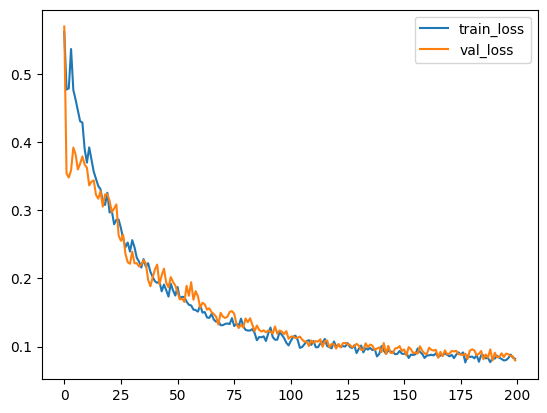

In [54]:
trainer.run(200)
criterion.loss_tracker.plot_losses()

# Testing On Simulation Data

In [55]:
import json
from pathlib import Path

file_name1 = 'I1_and_I2'
file_name2 = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.pkl"
data1 = pd.read_pickle(DATA_PATH)
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.pkl"
data2 = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.json"
with open(CONFIG_PATH, "r") as f:
    config1 = json.load(f)
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.json"
with open(CONFIG_PATH, "r") as f:
    config2 = json.load(f)
labels = config1["labels"]  # Should have the same labels
intensity = config1["features"]
pulsation_ratio = config2["features"]

data = pd.merge(data1, data2, on=labels, how="inner")

# Cleanup
data.dropna(inplace=True)
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 4.0)
    & (data["Maternal Wall Thickness"] <= 20.0)
]
print("training with", len(data), "samples")

training with 282744 samples


In [56]:
from sklearn import preprocessing 

x_columns = pulsation_ratio
y_columns = ["Fetal Saturation"]

y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

In [57]:
dataloader_gen = DataLoaderGenerator(data, x_columns, y_columns, 32, {"shuffle": True})
validation_method = RandomSplit(0.8)
criterion = TorchLossWrapper(torch.nn.MSELoss())
model = INN2(len(x_columns), 5, len(y_columns))

# trainer = CustomModelTrainer1(model, dataloader_gen, validation_method, criterion)
trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer.set_optimizer(torch.optim.SGD, {"lr": 5e-4})

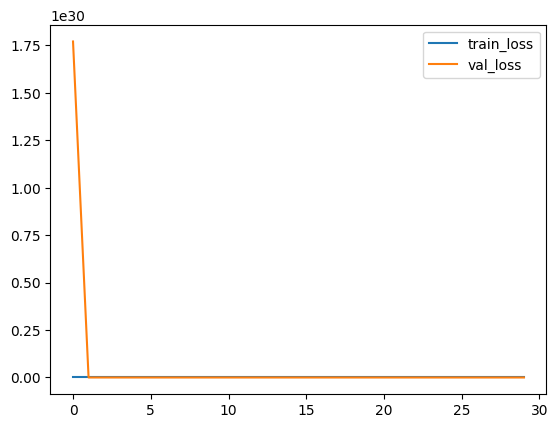

In [58]:
trainer.run(30)
criterion.loss_tracker.plot_losses()

In [61]:
criterion.loss_tracker.epoch_losses

{'train_loss': [0.6985823930949837,
  0.3469284554108954,
  0.2515642903613427,
  0.21319466903868972,
  0.1902299236497265,
  0.17512661182386297,
  0.16483776187604565,
  0.15686929490733964,
  0.1487996979166138,
  0.14335282461069265,
  0.1390244018413998,
  0.13517173472067298,
  0.13051480383960423,
  0.1279341574620747,
  0.12568412142496016,
  0.12118602944423378,
  0.12108267227356126,
  0.11693636963478847,
  0.11616666104988661,
  0.11413256584578794,
  0.11217070484715981,
  0.11083892783555069,
  0.10949806617655905,
  0.10862048238335097,
  0.10891663671685532,
  0.10648954942114182,
  0.10573770034563416,
  0.10386881780357311,
  0.10328847920375327,
  0.10189323212523506],
 'val_loss': [1.7689767605167538e+30,
  2.0561432215856694e+18,
  8804129455632.438,
  4.32294118587509e+18,
  56703306672.73821,
  7173652885.671226,
  0.2481782201454212,
  0.11169936056185632,
  0.19913524320998074,
  2.048271473724715,
  0.544128945593541,
  0.14297646371441222,
  7233.13466504301

In [59]:
import torchinfo
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
INN2                                     --
├─Sequential: 1-1                        --
│    └─AffineCouplingLayer: 2-1          --
│    │    └─Sequential: 3-1              420
│    │    └─Sequential: 3-2              420
│    └─BatchNorm1d: 2-2                  80
│    └─AffineCouplingLayer: 2-3          --
│    │    └─Sequential: 3-3              420
│    │    └─Sequential: 3-4              420
│    └─BatchNorm1d: 2-4                  80
│    └─AffineCouplingLayer: 2-5          --
│    │    └─Sequential: 3-5              420
│    │    └─Sequential: 3-6              420
│    └─BatchNorm1d: 2-6                  80
│    └─AffineCouplingLayer: 2-7          --
│    │    └─Sequential: 3-7              420
│    │    └─Sequential: 3-8              420
│    └─BatchNorm1d: 2-8                  80
│    └─Linear: 2-9                       41
Total params: 3,721
Trainable params: 3,721
Non-trainable params: 0